#1. Initialize Environment for MySQL

In [1]:
# Installation and initial setup
!apt-get update
!apt-get install -y mysql-server
!pip install mysql-connector-python==8.0.33

# Start MySQL service
!service mysql start

# Configure MySQL root access
!sudo mysql -e "ALTER USER 'root'@'localhost' IDENTIFIED WITH mysql_native_password BY ''"
!sudo service mysql restart

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [60.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,627 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,545 k

 * Starting MySQL database server mysqld
su: warning: cannot change directory to /nonexistent: No such file or directory
   ...done.
 * Stopping MySQL database server mysqld
   ...done.
 * Starting MySQL database server mysqld
su: warning: cannot change directory to /nonexistent: No such file or directory
   ...done.


#2. Start WDAS Test Setup

In [1]:
import mysql.connector
import os
import secrets
import pandas as pd
import requests

def setup_wdas_testing():
    print("Starting WDAS test setup...")

    # Generate test credentials
    test_user = 'wdas_test_user'
    test_password = secrets.token_urlsafe(16)

    os.environ['MYSQL_TEST_USER'] = test_user
    os.environ['MYSQL_TEST_PASSWORD'] = test_password

    try:
        # Root connection
        root_conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            auth_plugin='mysql_native_password'
        )
        root_cursor = root_conn.cursor(buffered=True)

        # Database setup
        root_cursor.execute("DROP DATABASE IF EXISTS WDAS_TEST")
        root_cursor.execute("CREATE DATABASE WDAS_TEST")
        root_cursor.execute("USE WDAS_TEST")

        # User setup
        root_cursor.execute(f"DROP USER IF EXISTS '{test_user}'@'localhost'")
        root_cursor.execute(
            f"CREATE USER '{test_user}'@'localhost' IDENTIFIED BY '{test_password}'"
        )
        root_cursor.execute(f"GRANT ALL PRIVILEGES ON WDAS_TEST.* TO '{test_user}'@'localhost'")
        root_cursor.execute("FLUSH PRIVILEGES")

        root_conn.commit()

        # Create tables
        tables_sql = [
            """
            CREATE TABLE LOGS (
                log_id INT AUTO_INCREMENT PRIMARY KEY,
                log_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                table_name VARCHAR(50) NOT NULL,
                operation VARCHAR(50) NOT NULL,
                details TEXT,
                performed_by INT
            )
            """,
            """
            CREATE TABLE USERS (
                user_id INT AUTO_INCREMENT PRIMARY KEY,
                username VARCHAR(50) NOT NULL UNIQUE,
                password_hash VARCHAR(255) NOT NULL,
                role ENUM('Admin', 'Researcher', 'Viewer') DEFAULT 'Viewer',
                creation_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
            """,
            """
            ALTER TABLE LOGS
            ADD CONSTRAINT fk_logs_users
            FOREIGN KEY (performed_by) REFERENCES USERS(user_id) ON DELETE SET NULL
            """,
            """
            CREATE TABLE USER_LOGS (
                log_id INT AUTO_INCREMENT PRIMARY KEY,
                log_timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                username VARCHAR(50) NOT NULL,
                operation VARCHAR(50) NOT NULL,
                performed_by INT,
                FOREIGN KEY (performed_by) REFERENCES USERS(user_id) ON DELETE SET NULL
            )
            """,
            """
            CREATE TABLE DATASET_DETAILS (
                dataset_id INT AUTO_INCREMENT PRIMARY KEY,
                dataset_name VARCHAR(255) NOT NULL,
                dataset_date DATE NOT NULL,
                researcher VARCHAR(100),
                notes TEXT,
                created_by INT,
                FOREIGN KEY (created_by) REFERENCES USERS(user_id) ON DELETE SET NULL
            )
            """,
            """
            CREATE TABLE DATASETS (
                dataset_id INT NOT NULL,
                sample_ref INT NOT NULL,
                frequency_of_sampling INT,
                pressure FLOAT,
                tempr FLOAT,
                M1 FLOAT,
                M2 FLOAT,
                M3 FLOAT,
                A1 FLOAT,
                A2 FLOAT,
                A3 FLOAT,
                Aw1 FLOAT,
                Aw2 FLOAT,
                Aw3 FLOAT,
                Mw1 FLOAT,
                Mw2 FLOAT,
                Mw3 FLOAT,
                Pitch FLOAT,
                Head FLOAT,
                Roll FLOAT,
                PRIMARY KEY (dataset_id, sample_ref),
                FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
                INDEX idx_pressure (pressure),
                INDEX idx_sample_ref (sample_ref)
            )
            """,
            """
            CREATE TABLE BEHAVIOR_TYPES (
                behavior_type_id INT AUTO_INCREMENT PRIMARY KEY,
                label VARCHAR(255) UNIQUE NOT NULL
            )
            """,
            """
            CREATE TABLE ANNOTATIONS (
                annotation_id INT AUTO_INCREMENT PRIMARY KEY,
                dataset_id INT NOT NULL,
                start_sample INT NOT NULL,
                end_sample INT NOT NULL,
                classification_label VARCHAR(255) NOT NULL,
                behavior_type VARCHAR(255),
                confidence_score FLOAT,
                FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
                FOREIGN KEY (behavior_type) REFERENCES BEHAVIOR_TYPES(label),
                CONSTRAINT check_samples CHECK (start_sample <= end_sample),
                INDEX idx_classification (classification_label),
                INDEX idx_behavior_type (behavior_type)
            )
            """,
            """
            CREATE TABLE ANNOTATION_HISTORY (
                history_id INT AUTO_INCREMENT PRIMARY KEY,
                annotation_id INT NOT NULL,
                previous_behavior_label VARCHAR(255),
                updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                updated_by VARCHAR(50),
                reason_for_change TEXT,
                FOREIGN KEY (annotation_id) REFERENCES ANNOTATIONS(annotation_id) ON DELETE CASCADE
            )
            """,
            """
            CREATE TABLE IMPORT_LOGS (
                log_id INT AUTO_INCREMENT PRIMARY KEY,
                file_path VARCHAR(255) NOT NULL,
                error_message TEXT,
                dataset_id INT,
                performed_by INT,
                import_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
                FOREIGN KEY (performed_by) REFERENCES USERS(user_id) ON DELETE SET NULL
            )
            """,
            """
            CREATE TABLE DIVE_STATS (
                dive_id INT AUTO_INCREMENT PRIMARY KEY,
                dataset_id INT NOT NULL,
                start_time INT NOT NULL,
                end_time INT NOT NULL,
                max_depth FLOAT NOT NULL,
                time_max_depth INT,
                duration INT NOT NULL,
                dest_st INT,
                dest_et INT,
                dest_dur INT,
                to_dur INT,
                from_dur INT,
                to_rate FLOAT,
                from_rate FLOAT,
                additional_metrics TEXT,
                FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
                CONSTRAINT check_times CHECK (start_time <= end_time)
            )
            """,
            """
            CREATE TABLE DERIVED_METRICS (
                metric_id INT AUTO_INCREMENT PRIMARY KEY,
                dataset_id INT NOT NULL,
                dive_id INT,
                metric_name VARCHAR(255) NOT NULL,
                metric_value FLOAT NOT NULL,
                calculated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (dataset_id) REFERENCES DATASET_DETAILS(dataset_id) ON DELETE CASCADE,
                FOREIGN KEY (dive_id) REFERENCES DIVE_STATS(dive_id) ON DELETE SET NULL
            )
            """,
            """
            CREATE TABLE MACHINE_LEARNING_MODELS (
                model_id INT AUTO_INCREMENT PRIMARY KEY,
                model_name VARCHAR(255) NOT NULL,
                model_type VARCHAR(255) NOT NULL,
                trained_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
            )
            """,
            """
            CREATE TABLE ML_CLASSIFICATIONS (
                classification_id INT AUTO_INCREMENT PRIMARY KEY,
                dive_id INT NOT NULL,
                event_t0 BIGINT NOT NULL,
                event_tn BIGINT NOT NULL,
                label VARCHAR(255) NOT NULL,
                model_id INT NOT NULL,
                confidence_score FLOAT NOT NULL,
                FOREIGN KEY (dive_id) REFERENCES DIVE_STATS(dive_id) ON DELETE CASCADE,
                FOREIGN KEY (model_id) REFERENCES MACHINE_LEARNING_MODELS(model_id) ON DELETE CASCADE,
                INDEX idx_label_confidence (label, confidence_score)
            )
            """
        ]

        # Create views
        views_sql = [
            """
            CREATE VIEW DatasetSummary AS
            SELECT
                d.dataset_id,
                d.dataset_name,
                d.dataset_date,
                a.annotation_id,
                a.start_sample,
                a.end_sample,
                a.classification_label,
                a.behavior_type,
                m.metric_id,
                m.metric_name,
                m.metric_value
            FROM DATASET_DETAILS d
            LEFT JOIN ANNOTATIONS a ON d.dataset_id = a.dataset_id
            LEFT JOIN DERIVED_METRICS m ON d.dataset_id = m.dataset_id
            """,
            """
            CREATE VIEW DiveClassificationSummary AS
            SELECT
                ds.dive_id,
                ds.dataset_id,
                ds.start_time,
                ds.end_time,
                ds.max_depth,
                c.classification_id,
                c.label,
                c.confidence_score
            FROM DIVE_STATS ds
            LEFT JOIN ML_CLASSIFICATIONS c ON ds.dive_id = c.dive_id
            """
        ]

        # Create procedures
        procedures_sql = [
            """
            CREATE PROCEDURE UploadDataset(
                IN csv_file_path VARCHAR(255),
                IN user_id INT
            )
            BEGIN
                DECLARE import_count INT;

                SELECT COUNT(*) INTO import_count
                FROM IMPORT_LOGS
                WHERE performed_by = user_id
                AND import_time > DATE_SUB(NOW(), INTERVAL 1 HOUR);

                IF import_count > 10 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'Rate limit exceeded. Please try again later.';
                END IF;

                IF csv_file_path IS NULL OR LENGTH(csv_file_path) = 0 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'CSV file path is missing or invalid.';
                END IF;

                SET @query = CONCAT(
                    'LOAD DATA INFILE "', csv_file_path, '" INTO TABLE DATASETS ',
                    'FIELDS TERMINATED BY "," ENCLOSED BY "\\"" ',
                    'LINES TERMINATED BY "\\n" IGNORE 1 ROWS;'
                );
                PREPARE stmt FROM @query;
                EXECUTE stmt;
                DEALLOCATE PREPARE stmt;
            END
            """,
            """
            CREATE PROCEDURE UploadAnnotations(
                IN csv_file_path VARCHAR(255),
                IN user_id INT
            )
            BEGIN
                DECLARE import_count INT;

                SELECT COUNT(*) INTO import_count
                FROM IMPORT_LOGS
                WHERE performed_by = user_id
                AND import_time > DATE_SUB(NOW(), INTERVAL 1 HOUR);

                IF import_count > 10 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'Rate limit exceeded. Please try again later.';
                END IF;

                IF csv_file_path IS NULL OR LENGTH(csv_file_path) = 0 THEN
                    SIGNAL SQLSTATE '45000'
                    SET MESSAGE_TEXT = 'CSV file path is missing or invalid.';
                END IF;

                SET @query = CONCAT(
                    'LOAD DATA INFILE "', csv_file_path, '" INTO TABLE ANNOTATIONS ',
                    'FIELDS TERMINATED BY "," ENCLOSED BY "\\"" ',
                    'LINES TERMINATED BY "\\n" IGNORE 1 ROWS;'
                );
                PREPARE stmt FROM @query;
                EXECUTE stmt;
                DEALLOCATE PREPARE stmt;
            END
            """
        ]

        # Create triggers
        triggers_sql = [
            """
            CREATE TRIGGER LogDatasetInsert
            AFTER INSERT ON DATASET_DETAILS
            FOR EACH ROW
            BEGIN
                INSERT INTO LOGS (log_timestamp, table_name, operation, details, performed_by)
                VALUES (NOW(), 'DATASET_DETAILS', 'INSERT', CONCAT('New dataset added: ', NEW.dataset_name), NEW.created_by);
            END
            """,
            """
            CREATE TRIGGER LogAnnotationChange
            AFTER UPDATE ON ANNOTATIONS
            FOR EACH ROW
            BEGIN
                INSERT INTO ANNOTATION_HISTORY (
                    annotation_id,
                    previous_behavior_label,
                    updated_at,
                    updated_by,
                    reason_for_change
                )
                VALUES (
                    OLD.annotation_id,
                    OLD.classification_label,
                    NOW(),
                    USER(),
                    'Classification or behavior type updated.'
                );
            END
            """
        ]

        # Execute all SQL statements
        print("Creating tables...")
        for sql in tables_sql:
            root_cursor.execute(sql)
            root_conn.commit()

        print("Creating views...")
        for sql in views_sql:
            root_cursor.execute(sql)
            root_conn.commit()

        print("Creating procedures...")
        for sql in procedures_sql:
            root_cursor.execute(sql)
            root_conn.commit()

        print("Creating triggers...")
        for sql in triggers_sql:
            root_cursor.execute(sql)
            root_conn.commit()

        # Grant privileges
        # Create users and grant privileges
        print("Setting up users and privileges...")
        try:
            # Create users first
            root_cursor.execute("CREATE USER IF NOT EXISTS 'viewer'@'localhost' IDENTIFIED BY 'viewer_password'")
            root_cursor.execute("CREATE USER IF NOT EXISTS 'researcher'@'localhost' IDENTIFIED BY 'researcher_password'")
            root_cursor.execute("CREATE USER IF NOT EXISTS 'admin'@'localhost' IDENTIFIED BY 'admin_password'")

            # Then grant privileges
            root_cursor.execute("GRANT SELECT ON WDAS_TEST.* TO 'viewer'@'localhost'")
            root_cursor.execute("GRANT SELECT, INSERT, UPDATE ON WDAS_TEST.* TO 'researcher'@'localhost'")
            root_cursor.execute("GRANT ALL PRIVILEGES ON WDAS_TEST.* TO 'admin'@'localhost'")
            root_cursor.execute("FLUSH PRIVILEGES")
            root_conn.commit()

            print("Users and privileges setup completed successfully!")

        except mysql.connector.Error as err:
            print(f"Error setting up users and privileges: {err}")
            # Continue execution even if user creation fails
            pass

        print("Database setup completed successfully!")

    except mysql.connector.Error as err:
        print(f"MySQL Error: {err}")
        print(f"Error Code: {err.errno}")
        print(f"SQLSTATE: {err.sqlstate}")
        print(f"Error Message: {err.msg}")
        return
    finally:
        if 'root_cursor' in locals():
            root_cursor.close()
        if 'root_conn' in locals():
            root_conn.close()

# Call the setup function
setup_wdas_testing()

Starting WDAS test setup...
Creating tables...
Creating views...
Creating procedures...
Creating triggers...
Setting up users and privileges...
Users and privileges setup completed successfully!
Database setup completed successfully!


#3. Connect to WDAS database

In [2]:
import mysql.connector
import pandas as pd
from datetime import datetime

def test_wdas_database():
    # Connect to the database using the test user credentials
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user=os.environ.get('MYSQL_TEST_USER'),
            password=os.environ.get('MYSQL_TEST_PASSWORD'),
            database="WDAS_TEST"
        )
        cursor = conn.cursor(dictionary=True)  # Returns results as dictionaries

        print("1. Testing User Creation")
        print("-----------------------")
        # Create a test user
        cursor.execute("""
            INSERT INTO USERS (username, password_hash, role)
            VALUES ('test_researcher', SHA2('test_password', 256), 'Researcher')
        """)
        conn.commit()

        # Verify user creation
        cursor.execute("SELECT username, role FROM USERS WHERE username = 'test_researcher'")
        print("Created user:", cursor.fetchone())

        print("\n2. Testing Dataset Creation")
        print("---------------------------")
        # Create a dataset
        cursor.execute("""
            INSERT INTO DATASET_DETAILS (dataset_name, dataset_date, researcher, notes)
            VALUES ('Test Dive Dataset', CURRENT_DATE, 'test_researcher', 'Test dataset for verification')
        """)
        dataset_id = cursor.lastrowid
        conn.commit()

        # Verify dataset creation
        cursor.execute("SELECT * FROM DATASET_DETAILS WHERE dataset_id = %s", (dataset_id,))
        print("Created dataset:", cursor.fetchone())

        print("\n3. Testing Data Insertion")
        print("-------------------------")
        # Insert sample dive data
        sample_data = [
            (dataset_id, 1, 100, 15.5, 20.1),  # sample_ref, pressure, temperature
            (dataset_id, 2, 102, 15.7, 20.2),
            (dataset_id, 3, 105, 15.9, 20.3)
        ]

        cursor.executemany("""
            INSERT INTO DATASETS (dataset_id, sample_ref, frequency_of_sampling, pressure, tempr)
            VALUES (%s, %s, %s, %s, %s)
        """, sample_data)
        conn.commit()

        # Verify data insertion
        cursor.execute("SELECT * FROM DATASETS WHERE dataset_id = %s", (dataset_id,))
        print("Inserted data samples:", cursor.fetchall())

        print("\n4. Testing Behavior Types and Annotations")
        print("----------------------------------------")
        # Create behavior type
        cursor.execute("INSERT INTO BEHAVIOR_TYPES (label) VALUES ('Diving')")
        conn.commit()

        # Create annotation
        cursor.execute("""
            INSERT INTO ANNOTATIONS
            (dataset_id, start_sample, end_sample, classification_label, behavior_type, confidence_score)
            VALUES (%s, %s, %s, %s, %s, %s)
        """, (dataset_id, 1, 3, 'Deep Dive', 'Diving', 0.95))
        conn.commit()

        # Verify annotations
        cursor.execute("""
            SELECT a.*, b.label as behavior_label
            FROM ANNOTATIONS a
            JOIN BEHAVIOR_TYPES b ON a.behavior_type = b.label
            WHERE a.dataset_id = %s
        """, (dataset_id,))
        print("Created annotation:", cursor.fetchone())

        print("\n5. Testing Views")
        print("----------------")
        cursor.execute("SELECT * FROM DatasetSummary WHERE dataset_id = %s", (dataset_id,))
        print("Dataset Summary View:", cursor.fetchall())

        print("\n6. Testing Triggers")
        print("-------------------")
        # Check if the dataset insert was logged
        cursor.execute("SELECT * FROM LOGS WHERE table_name = 'DATASET_DETAILS'")
        print("Log entries:", cursor.fetchall())

        # Update an annotation to test the annotation history trigger
        cursor.execute("""
            UPDATE ANNOTATIONS
            SET classification_label = 'Updated Deep Dive'
            WHERE dataset_id = %s
        """, (dataset_id,))
        conn.commit()

        cursor.execute("SELECT * FROM ANNOTATION_HISTORY")
        print("Annotation history entries:", cursor.fetchall())

    except mysql.connector.Error as err:
        print(f"Error: {err}")
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Run the tests
test_wdas_database()

1. Testing User Creation
-----------------------
Created user: {'username': 'test_researcher', 'role': 'Researcher'}

2. Testing Dataset Creation
---------------------------
Created dataset: {'dataset_id': 1, 'dataset_name': 'Test Dive Dataset', 'dataset_date': datetime.date(2024, 12, 17), 'researcher': 'test_researcher', 'notes': 'Test dataset for verification', 'created_by': None}

3. Testing Data Insertion
-------------------------
Inserted data samples: [{'dataset_id': 1, 'sample_ref': 1, 'frequency_of_sampling': 100, 'pressure': 15.5, 'tempr': 20.1, 'M1': None, 'M2': None, 'M3': None, 'A1': None, 'A2': None, 'A3': None, 'Aw1': None, 'Aw2': None, 'Aw3': None, 'Mw1': None, 'Mw2': None, 'Mw3': None, 'Pitch': None, 'Head': None, 'Roll': None}, {'dataset_id': 1, 'sample_ref': 2, 'frequency_of_sampling': 102, 'pressure': 15.7, 'tempr': 20.2, 'M1': None, 'M2': None, 'M3': None, 'A1': None, 'A2': None, 'A3': None, 'Aw1': None, 'Aw2': None, 'Aw3': None, 'Mw1': None, 'Mw2': None, 'Mw3': Non

In [3]:
def cleanup_test_dataset(conn_params):
    conn = mysql.connector.connect(**conn_params)
    cursor = conn.cursor()

    try:
        # Remove test dataset
        cursor.execute("DELETE FROM DATASET_DETAILS WHERE dataset_name = 'Test Dive Dataset'")
        conn.commit()
        print("Test dataset removed successfully")

        # Verify cleanup
        cursor.execute("""
            SELECT
                dataset_id,
                dataset_name,
                (SELECT COUNT(*) FROM DATASETS d WHERE d.dataset_id = dd.dataset_id) as row_count
            FROM DATASET_DETAILS dd
        """)

        datasets = cursor.fetchall()
        print("\nRemaining datasets:")
        for dataset_id, name, count in datasets:
            print(f"ID: {dataset_id}, Name: {name}, Rows: {count}")

    except Exception as e:
        print(f"Error during cleanup: {e}")
        conn.rollback()
    finally:
        cursor.close()
        conn.close()

# Run cleanup
conn_params = {
    "host": "localhost",
    "user": os.environ.get('MYSQL_TEST_USER'),
    "password": os.environ.get('MYSQL_TEST_PASSWORD'),
    "database": "WDAS_TEST"
}

cleanup_test_dataset(conn_params)

Test dataset removed successfully

Remaining datasets:


#4. Import Biolog Data

In [4]:
import mysql.connector
import pandas as pd
import requests
import io
from datetime import datetime

def download_github_file(url):
    """Download raw content from GitHub."""
    raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
    print(f"Downloading from: {raw_url}")

    response = requests.get(raw_url)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    else:
        raise Exception(f"Failed to download file: {response.status_code}")

def clean_column_names(df):
    """Clean column names to match database schema."""
    # Replace dots with empty string and standardize temperature column
    df.columns = df.columns.str.replace('.', '')
    if 'temperature' in df.columns:
        df = df.rename(columns={'temperature': 'tempr'})
    return df

def import_whale_data(conn_params):
    try:
        # Connect to database
        conn = mysql.connector.connect(**conn_params)
        cursor = conn.cursor(dictionary=True)

        # Create dataset entry
        dataset_name = "MinML_Whale_Data"
        print(f"Creating dataset entry: {dataset_name}")
        cursor.execute("""
            INSERT INTO DATASET_DETAILS
            (dataset_name, dataset_date, researcher, notes)
            VALUES (%s, %s, %s, %s)
        """, (dataset_name, datetime.now(), "automated_import", "Whale behavioral data from MinML project"))
        dataset_id = cursor.lastrowid
        conn.commit()

        # Import main dataset
        print("\nImporting main dataset...")
        data_url = "https://github.com/GilRaitses/minML/blob/main/data/data.csv"
        df = download_github_file(data_url)
        df = clean_column_names(df)
        print(f"Downloaded {len(df)} records")

        # Prepare and insert the data
        print("Inserting data records...")
        records_inserted = 0

        for index, row in df.iterrows():
            try:
                cursor.execute("""
                    INSERT INTO DATASETS
                    (dataset_id, sample_ref,
                     pressure, tempr,
                     M1, M2, M3,
                     A1, A2, A3,
                     Aw1, Aw2, Aw3,
                     Mw1, Mw2, Mw3,
                     Pitch, Head, Roll)
                    VALUES
                    (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
                """, (
                    dataset_id, row.get('s', index),
                    row.get('p', 0), row.get('tempr', 0),
                    row.get('M1', 0), row.get('M2', 0), row.get('M3', 0),
                    row.get('A1', 0), row.get('A2', 0), row.get('A3', 0),
                    row.get('Aw1', 0), row.get('Aw2', 0), row.get('Aw3', 0),
                    row.get('Mw1', 0), row.get('Mw2', 0), row.get('Mw3', 0),
                    row.get('pitch', 0), row.get('head', 0), row.get('roll', 0)
                ))
                records_inserted += 1

                if records_inserted % 1000 == 0:
                    print(f"Inserted {records_inserted} records...")
                    conn.commit()

            except Exception as e:
                print(f"Error inserting row {index}: {e}")
                continue

        conn.commit()
        print(f"\nTotal records inserted: {records_inserted}")

        # Verify import
        cursor.execute("""
            SELECT COUNT(*) as count,
                   AVG(pressure) as avg_pressure,
                   AVG(Mw1) as avg_mw1
            FROM DATASETS
            WHERE dataset_id = %s
        """, (dataset_id,))
        stats = cursor.fetchone()
        print("\nImport verification:")
        print(f"Records count: {stats['count']}")
        print(f"Average pressure: {stats['avg_pressure']:.2f}")
        print(f"Average Mw1: {stats['avg_mw1']:.2f}")

    except Exception as e:
        print(f"Error: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Example usage:
conn_params = {
    "host": "localhost",
    "user": os.environ.get('MYSQL_TEST_USER'),
    "password": os.environ.get('MYSQL_TEST_PASSWORD'),
    "database": "WDAS_TEST"
}

import_whale_data(conn_params)

Creating dataset entry: MinML_Whale_Data

Importing main dataset...
Downloaded 99925 records
Inserting data records...
Inserted 1000 records...
Inserted 2000 records...
Inserted 3000 records...
Inserted 4000 records...
Inserted 5000 records...
Inserted 6000 records...
Inserted 7000 records...
Inserted 8000 records...
Inserted 9000 records...
Inserted 10000 records...
Inserted 11000 records...
Inserted 12000 records...
Inserted 13000 records...
Inserted 14000 records...
Inserted 15000 records...
Inserted 16000 records...
Inserted 17000 records...
Inserted 18000 records...
Inserted 19000 records...
Inserted 20000 records...
Inserted 21000 records...
Inserted 22000 records...
Inserted 23000 records...
Inserted 24000 records...
Inserted 25000 records...
Inserted 26000 records...
Inserted 27000 records...
Inserted 28000 records...
Inserted 29000 records...
Inserted 30000 records...
Inserted 31000 records...
Inserted 32000 records...
Inserted 33000 records...
Inserted 34000 records...
Insert

In [5]:
def verify_dataset(conn_params):
    conn = mysql.connector.connect(**conn_params)
    cursor = conn.cursor(dictionary=True)

    # Check dataset details
    cursor.execute("""
        SELECT
            dd.dataset_id,
            dd.dataset_name,
            dd.dataset_date,
            COUNT(d.sample_ref) as sample_count,
            MIN(d.sample_ref) as min_sample,
            MAX(d.sample_ref) as max_sample,
            MIN(d.pressure) as min_pressure,
            MAX(d.pressure) as max_pressure
        FROM DATASET_DETAILS dd
        LEFT JOIN DATASETS d ON dd.dataset_id = d.dataset_id
        GROUP BY dd.dataset_id, dd.dataset_name, dd.dataset_date
    """)

    datasets = cursor.fetchall()
    print("\nDataset Information:")
    for ds in datasets:
        print(f"\nID: {ds['dataset_id']}")
        print(f"Name: {ds['dataset_name']}")
        print(f"Date: {ds['dataset_date']}")
        print(f"Sample count: {ds['sample_count']}")
        print(f"Sample range: {ds['min_sample']} to {ds['max_sample']}")
        print(f"Pressure range: {ds['min_pressure']} to {ds['max_pressure']}")

    # Show a few sample rows
    if datasets:
        first_id = datasets[0]['dataset_id']
        cursor.execute("""
            SELECT sample_ref, pressure, tempr, pitch, roll, head
            FROM DATASETS
            WHERE dataset_id = %s
            LIMIT 3
        """, (first_id,))

        print("\nSample data rows:")
        for row in cursor.fetchall():
            print(row)

    cursor.close()
    conn.close()

# Run verification
conn_params = {
    "host": "localhost",
    "user": os.environ.get('MYSQL_TEST_USER'),
    "password": os.environ.get('MYSQL_TEST_PASSWORD'),
    "database": "WDAS_TEST"
}

verify_dataset(conn_params)


Dataset Information:

ID: 2
Name: MinML_Whale_Data
Date: 2024-12-17
Sample count: 99925
Sample range: 1 to 99925
Pressure range: -0.352956 to 39.4627

Sample data rows:
{'sample_ref': 1, 'pressure': 6.77603, 'tempr': 30.9446, 'pitch': -0.152577, 'roll': -0.300681, 'head': 2.86572}
{'sample_ref': 2, 'pressure': 6.85326, 'tempr': 31.0297, 'pitch': -0.139719, 'roll': -0.318641, 'head': -3.37475}
{'sample_ref': 3, 'pressure': 6.89239, 'tempr': 31.0778, 'pitch': -0.126531, 'roll': -0.35045, 'head': -3.40024}


#5. Visualize Whale Data

Dataset shape: (99925, 12)

Dataset columns: ['sample_ref', 'pressure', 'tempr', 'Mw1', 'Mw2', 'Mw3', 'Aw1', 'Aw2', 'Aw3', 'Pitch', 'Head', 'Roll']

First few rows of data:
   sample_ref  pressure    tempr      Mw1      Mw2      Mw3       Aw1  \
0           1   6.77603  30.9446 -14.0110  14.8746 -48.9973 -0.157126   
1           2   6.85326  31.0297 -14.4347  16.5681 -48.2674 -0.142539   
2           3   6.89239  31.0778 -15.2202  17.4997 -47.6766 -0.130602   
3           4   6.92735  30.9829 -15.4039  18.7164 -47.1183 -0.137075   
4           5   7.01109  31.0414 -15.4944  20.0464 -46.5016 -0.123617   

        Aw2       Aw3     Pitch     Head      Roll  
0 -0.302631  0.975969 -0.152577  2.86572 -0.300681  
1 -0.317518  0.962519 -0.139719 -3.37475 -0.318641  
2 -0.352471  0.964251 -0.126531 -3.40024 -0.350450  
3 -0.392653  0.948214 -0.132777  2.84638 -0.392601  
4 -0.403460  0.946066 -0.119618 -3.39415 -0.403107  

Annotations shape: (0, 0)


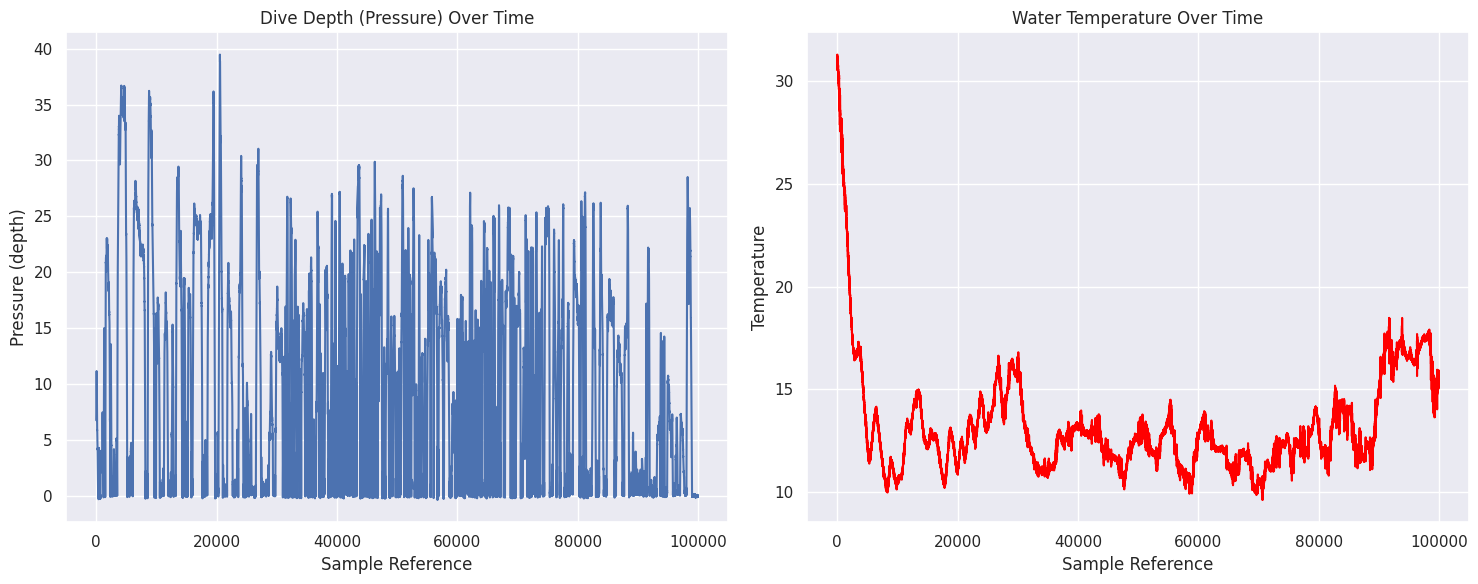

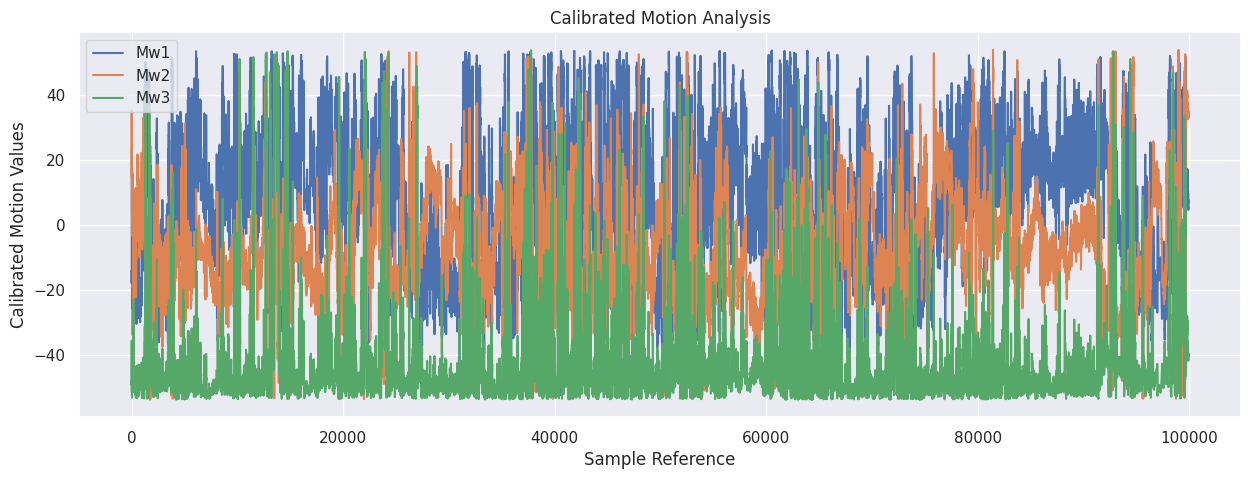

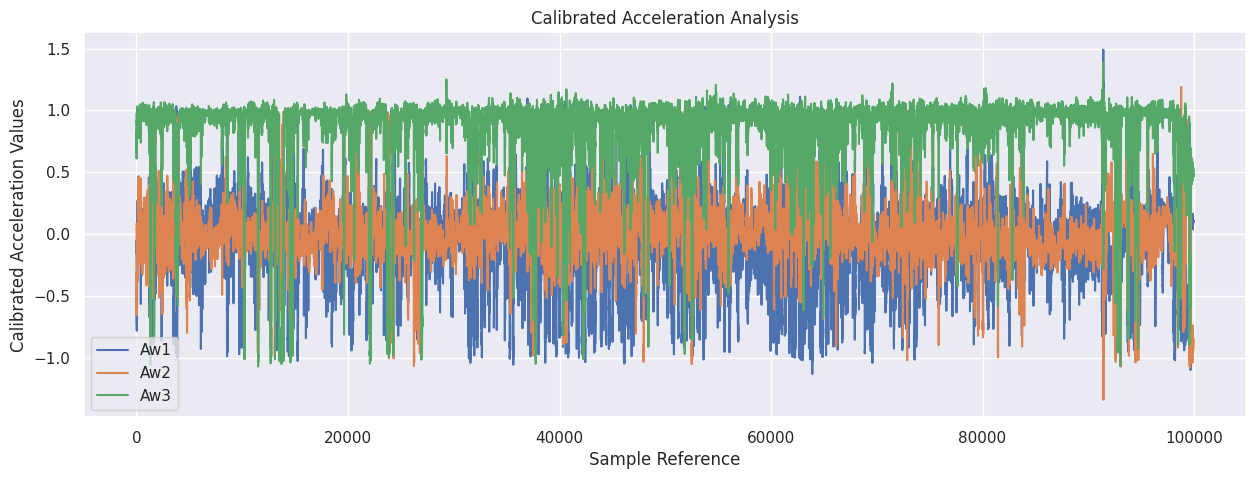


Statistical Summary of Metrics:
           pressure         tempr           Mw1           Mw2           Mw3  \
count  99925.000000  99925.000000  99925.000000  99925.000000  99925.000000   
mean      10.609066     13.228823      6.763895     -7.790611    -41.607433   
std        9.088614      2.609002     21.882983     17.005742     16.116647   
min       -0.352956      9.622080    -52.996400    -53.741300    -53.721100   
25%        1.782620     11.737000    -10.499400    -19.349700    -50.072200   
50%        9.425150     12.607800      9.087600     -8.820800    -47.092200   
75%       17.331300     13.811900     22.381600      3.110300    -40.490800   
max       39.462700     31.301000     53.713100     53.950400     53.778500   

                Aw1           Aw2           Aw3         Pitch          Head  \
count  99925.000000  99925.000000  99925.000000  99925.000000  99925.000000   
mean      -0.041197      0.025734      0.850842     -0.047989      0.208681   
std        0.35084

In [6]:
!pip install seaborn  # Install Seaborn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

def visualize_whale_data():
    try:
        # Connect to database
        conn = mysql.connector.connect(
            host="localhost",
            user=os.environ.get('MYSQL_TEST_USER'),
            password=os.environ.get('MYSQL_TEST_PASSWORD'),
            database="WDAS_TEST"
        )
        cursor = conn.cursor(dictionary=True)

        # 1. Get the basic dataset info
        cursor.execute("""
        SELECT dataset_id, dataset_name
        FROM DATASET_DETAILS
        ORDER BY dataset_id DESC LIMIT 1
        """)
        dataset_info = cursor.fetchone()
        dataset_id = int(dataset_info['dataset_id'])  # Convert to regular int

        # 2. Get the main data
        cursor.execute("""
        SELECT sample_ref, pressure, tempr,
               Mw1, Mw2, Mw3, Aw1, Aw2, Aw3,
               Pitch, Head, Roll
        FROM DATASETS
        WHERE dataset_id = %s
        ORDER BY sample_ref
        """, (dataset_id,))

        # Convert to pandas DataFrame
        data = cursor.fetchall()
        df = pd.DataFrame(data)

        # 3. Get annotations
        cursor.execute("""
        SELECT start_sample, end_sample, classification_label, behavior_type
        FROM ANNOTATIONS
        WHERE dataset_id = %s
        """, (dataset_id,))

        annotations_data = cursor.fetchall()
        annotations_df = pd.DataFrame(annotations_data)

        # Print data info before plotting
        print("Dataset shape:", df.shape)
        print("\nDataset columns:", df.columns.tolist())
        print("\nFirst few rows of data:")
        print(df.head())

        print("\nAnnotations shape:", annotations_df.shape)
        if not annotations_df.empty:
            print("\nFirst few annotations:")
            print(annotations_df.head())

        # Create visualizations
        sns.set_style("whitegrid") # Set a Seaborn style if you want
        sns.set_theme(style="darkgrid") # You can also use sns.set_theme

        # 1. Pressure and Temperature Over Time
        plt.figure(figsize=(15, 6))
        plt.subplot(1, 2, 1)
        plt.plot(df['sample_ref'], df['pressure'], label='Pressure')
        plt.title('Dive Depth (Pressure) Over Time')
        plt.xlabel('Sample Reference')
        plt.ylabel('Pressure (depth)')

        plt.subplot(1, 2, 2)
        plt.plot(df['sample_ref'], df['tempr'], label='Temperature', color='red')
        plt.title('Water Temperature Over Time')
        plt.xlabel('Sample Reference')
        plt.ylabel('Temperature')
        plt.tight_layout()
        plt.show()

        # 2. Calibrated Motion Analysis (Mw1, Mw2, Mw3)
        plt.figure(figsize=(15, 5))
        plt.plot(df['sample_ref'], df['Mw1'], label='Mw1')
        plt.plot(df['sample_ref'], df['Mw2'], label='Mw2')
        plt.plot(df['sample_ref'], df['Mw3'], label='Mw3')
        plt.title('Calibrated Motion Analysis')
        plt.xlabel('Sample Reference')
        plt.ylabel('Calibrated Motion Values')
        plt.legend()
        plt.show()

        # 3. Calibrated Acceleration Analysis (Aw1, Aw2, Aw3)
        plt.figure(figsize=(15, 5))
        plt.plot(df['sample_ref'], df['Aw1'], label='Aw1')
        plt.plot(df['sample_ref'], df['Aw2'], label='Aw2')
        plt.plot(df['sample_ref'], df['Aw3'], label='Aw3')
        plt.title('Calibrated Acceleration Analysis')
        plt.xlabel('Sample Reference')
        plt.ylabel('Calibrated Acceleration Values')
        plt.legend()
        plt.show()

        if not annotations_df.empty:
            # 4. Combined Visualization with Annotations
            plt.figure(figsize=(15, 10))

            # Create subplots
            ax1 = plt.subplot(311)  # Pressure
            ax2 = plt.subplot(312)  # Motion
            ax3 = plt.subplot(313)  # Acceleration

            # Plot pressure with annotations
            ax1.plot(df['sample_ref'], df['pressure'], label='Pressure', alpha=0.7)
            ax1.set_title('Dive Profile with Annotations')
            ax1.set_ylabel('Pressure (depth)')

            # Plot calibrated motion
            ax2.plot(df['sample_ref'], df['Mw1'], label='Mw1')
            ax2.plot(df['sample_ref'], df['Mw2'], label='Mw2')
            ax2.plot(df['sample_ref'], df['Mw3'], label='Mw3')
            ax2.set_title('Calibrated Motion')
            ax2.set_ylabel('Motion Values')
            ax2.legend()

            # Plot calibrated acceleration
            ax3.plot(df['sample_ref'], df['Aw1'], label='Aw1')
            ax3.plot(df['sample_ref'], df['Aw2'], label='Aw2')
            ax3.plot(df['sample_ref'], df['Aw3'], label='Aw3')
            ax3.set_title('Calibrated Acceleration')
            ax3.set_ylabel('Acceleration Values')
            ax3.set_xlabel('Sample Reference')
            ax3.legend()

            # Add annotations to all subplots
            colors = plt.cm.rainbow(np.linspace(0, 1, len(annotations_df)))
            for idx, annotation in annotations_df.iterrows():
                start = int(annotation['start_sample'])
                end = int(annotation['end_sample'])
                label = annotation['classification_label']
                alpha = 0.2

                for ax in [ax1, ax2, ax3]:
                    ax.axvspan(start, end, alpha=alpha, color=colors[idx],
                              label=f'Annotation: {label}')

            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

        # 5. Statistical Summary
        print("\nStatistical Summary of Metrics:")
        metrics = ['pressure', 'tempr', 'Mw1', 'Mw2', 'Mw3', 'Aw1', 'Aw2', 'Aw3', 'Pitch', 'Head', 'Roll']
        print(df[metrics].describe())

        # 6. Annotation Summary
        if not annotations_df.empty:
            print("\nAnnotation Summary:")
            print(f"Total number of annotations: {len(annotations_df)}")

            print("\nBehavior type distribution:")
            print(annotations_df['behavior_type'].value_counts())

            print("\nAnnotation duration statistics:")
            annotations_df['duration'] = annotations_df['end_sample'].astype(int) - annotations_df['start_sample'].astype(int)
            print(f"Mean duration: {annotations_df['duration'].mean():.2f} samples")
            print(f"Max duration: {annotations_df['duration'].max()} samples")
            print(f"Min duration: {annotations_df['duration'].min()} samples")

    except Exception as e:
        print(f"Error during visualization: {e}")
        raise  # This will show the full error traceback
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Run the visualization
visualize_whale_data()

#6. Import and Visualize Annotations



In [7]:
import mysql.connector
import pandas as pd
import requests
import io
from datetime import datetime

def import_whale_annotations(conn_params):
    """Import whale behavior annotations from MinML project."""
    try:
        # Connect to database
        conn = mysql.connector.connect(**conn_params)
        cursor = conn.cursor(dictionary=True)

        # Get the latest dataset_id
        cursor.execute("""
            SELECT dataset_id, dataset_name
            FROM DATASET_DETAILS
            ORDER BY dataset_id DESC LIMIT 1
        """)
        dataset_info = cursor.fetchone()
        dataset_id = dataset_info['dataset_id']

        # Download annotations
        annotations_url = "https://github.com/GilRaitses/minML/blob/main/annotations/annotations.csv"
        raw_url = annotations_url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
        print(f"Downloading annotations from: {raw_url}")

        response = requests.get(raw_url)
        if response.status_code != 200:
            raise Exception(f"Failed to download annotations: {response.status_code}")

        # Read and process annotations
        annotations_df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
        print(f"Downloaded {len(annotations_df)} annotations")

        # Get unique behaviors from both state and event columns separately
        unique_states = annotations_df['state'].unique().tolist()
        unique_events = annotations_df['event'].unique().tolist()
        unique_behaviors = list(set(unique_states + unique_events))

        # Insert behavior types
        for behavior in unique_behaviors:
            if pd.notna(behavior):  # Skip any NaN values
                cursor.execute("""
                    INSERT IGNORE INTO BEHAVIOR_TYPES (label)
                    VALUES (%s)
                """, (behavior,))
        conn.commit()

        # Insert annotations
        records_inserted = 0
        for _, row in annotations_df.iterrows():
            try:
                # Use event as the classification label and state as the behavior type
                cursor.execute("""
                    INSERT INTO ANNOTATIONS
                    (dataset_id, start_sample, end_sample,
                     classification_label, behavior_type, confidence_score)
                    VALUES (%s, %s, %s, %s, %s, %s)
                """, (
                    dataset_id,
                    row['eventStart'],  # start sample
                    row['eventEnd'],    # end sample
                    row['event'],       # specific event as classification
                    row['state'],       # higher-level state as behavior type
                    1.0                 # default confidence score
                ))
                records_inserted += 1

                if records_inserted % 10 == 0:  # Commit every 10 records
                    print(f"Inserted {records_inserted} annotations...")
                    conn.commit()

            except Exception as e:
                print(f"Error inserting annotation: {e}")
                continue

        conn.commit()
        print(f"\nTotal annotations inserted: {records_inserted}")

        # Verify import with detailed statistics
        print("\nBehavior Type Distribution:")
        cursor.execute("""
            SELECT behavior_type, COUNT(*) as count
            FROM ANNOTATIONS
            WHERE dataset_id = %s
            GROUP BY behavior_type
        """, (dataset_id,))

        for row in cursor.fetchall():
            print(f"{row['behavior_type']}: {row['count']} annotations")

        print("\nEvent Classification Distribution:")
        cursor.execute("""
            SELECT classification_label, COUNT(*) as count
            FROM ANNOTATIONS
            WHERE dataset_id = %s
            GROUP BY classification_label
        """, (dataset_id,))

        for row in cursor.fetchall():
            print(f"{row['classification_label']}: {row['count']} events")

        # Sample statistics
        cursor.execute("""
            SELECT
                MIN(end_sample - start_sample) as min_duration,
                MAX(end_sample - start_sample) as max_duration,
                AVG(end_sample - start_sample) as avg_duration
            FROM ANNOTATIONS
            WHERE dataset_id = %s
        """, (dataset_id,))

        duration_stats = cursor.fetchone()
        print("\nDuration Statistics (in samples):")
        print(f"Minimum duration: {duration_stats['min_duration']}")
        print(f"Maximum duration: {duration_stats['max_duration']}")
        print(f"Average duration: {duration_stats['avg_duration']:.2f}")

    except Exception as e:
        print(f"Error: {e}")
        raise
    finally:
        if 'cursor' in locals():
            cursor.close()
        if 'conn' in locals():
            conn.close()

# Example usage:
conn_params = {
    "host": "localhost",
    "user": os.environ.get('MYSQL_TEST_USER'),
    "password": os.environ.get('MYSQL_TEST_PASSWORD'),
    "database": "WDAS_TEST"
}

import_whale_annotations(conn_params)

Downloaded 51 annotations
Inserted 10 annotations...
Inserted 20 annotations...
Inserted 30 annotations...
Inserted 40 annotations...
Inserted 50 annotations...

Total annotations inserted: 51

Behavior Type Distribution:
End: 1 annotations
Feeding: 49 annotations
Traveling: 1 annotations

Event Classification Distribution:
End: 1 events
Exploratory dives: 14 events
Feeding loop: 5 events
Kick feeding: 7 events
Noodle feeding: 7 events
Side rolls: 12 events
Side rolls and loop: 2 events
Surface Active: 1 events
Traveling: 1 events
Vertical loop: 1 events

Duration Statistics (in samples):
Minimum duration: 0
Maximum duration: 1619
Average duration: 391.92



Available Annotations:
ID: 2, Type: Side rolls, Duration: 79.8s
ID: 3, Type: Side rolls, Duration: 119.8s
ID: 4, Type: Exploratory dives, Duration: 168.0s
ID: 5, Type: Side rolls, Duration: 176.8s
ID: 6, Type: Side rolls, Duration: 57.0s
ID: 7, Type: Side rolls, Duration: 35.8s
ID: 8, Type: Side rolls, Duration: 105.8s
ID: 9, Type: Exploratory dives, Duration: 114.0s
ID: 10, Type: Side rolls, Duration: 58.4s
ID: 11, Type: Side rolls, Duration: 53.8s
ID: 12, Type: Side rolls and loop, Duration: 72.0s
ID: 13, Type: Side rolls, Duration: 59.8s
ID: 14, Type: Feeding loop, Duration: 61.8s
ID: 15, Type: Side rolls, Duration: 54.8s
ID: 16, Type: Exploratory dives, Duration: 121.8s
ID: 17, Type: Kick feeding, Duration: 49.6s
ID: 18, Type: Kick feeding, Duration: 23.6s
ID: 19, Type: Kick feeding, Duration: 36.2s
ID: 20, Type: Exploratory dives, Duration: 50.8s
ID: 21, Type: Noodle feeding, Duration: 56.8s
ID: 22, Type: Noodle feeding, Duration: 73.2s
ID: 23, Type: Exploratory dives, Duration: 

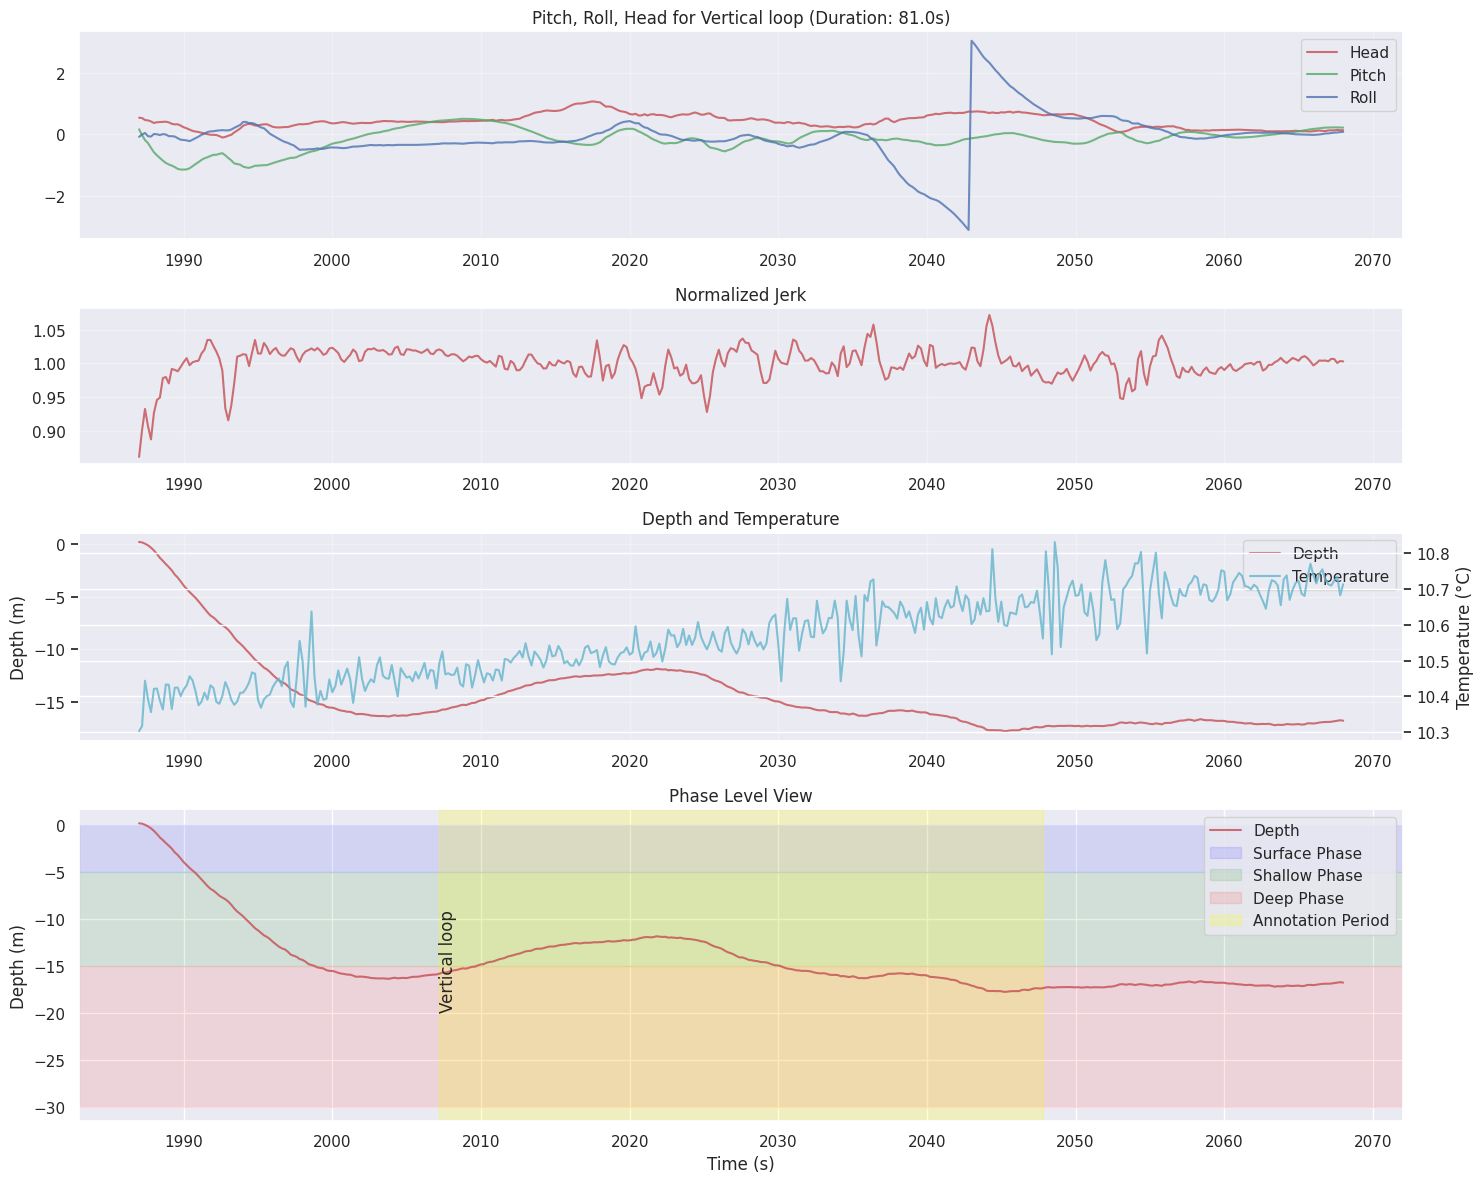


Annotation Details:
Classification: Vertical loop
Behavior Type: Feeding
Duration: 40.6 seconds


In [8]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_annotation_detail(conn_params, annotation_id=1):
    """Create detailed visualization for a single annotation."""

    # Connect to database
    conn = mysql.connector.connect(**conn_params)
    cursor = conn.cursor(dictionary=True)

    # Get annotation details with more context
    cursor.execute("""
        SELECT
            a.*,
            d.dataset_name,
            MIN(ds.sample_ref) as min_sample,
            MAX(ds.sample_ref) as max_sample
        FROM ANNOTATIONS a
        JOIN DATASET_DETAILS d ON a.dataset_id = d.dataset_id
        JOIN DATASETS ds ON a.dataset_id = ds.dataset_id
        WHERE a.annotation_id = %s
        GROUP BY a.annotation_id, d.dataset_name
    """, (annotation_id,))
    annotation = cursor.fetchone()

    if not annotation:
        print(f"No annotation found with ID {annotation_id}")
        return

    # Get data for the annotation period (with more padding)
    padding = int((annotation['end_sample'] - annotation['start_sample']) * 0.5)  # 50% padding
    start_sample = max(annotation['min_sample'], annotation['start_sample'] - padding)
    end_sample = min(annotation['max_sample'], annotation['end_sample'] + padding)

    # Debug info
    print(f"Fetching data from sample {start_sample} to {end_sample}")
    print(f"Annotation period: {annotation['start_sample']} to {annotation['end_sample']}")

    cursor.execute("""
        SELECT
            sample_ref/5.0 as time,  # Convert to seconds (5Hz sampling rate)
            pressure as depth,
            tempr,
            pitch,
            roll,
            head,
            SQRT(POW(Aw1, 2) + POW(Aw2, 2) + POW(Aw3, 2)) as norm_jerk
        FROM DATASETS
        WHERE dataset_id = %s
        AND sample_ref BETWEEN %s AND %s
        ORDER BY sample_ref
    """, (annotation['dataset_id'], start_sample, end_sample))

    # Convert to DataFrame
    df = pd.DataFrame(cursor.fetchall())

    if df.empty:
        print("No data found for this annotation period")
        return

    print(f"Retrieved {len(df)} data points")
    print("Time range:", df['time'].min(), "to", df['time'].max())

    # Create figure with GridSpec
    fig = plt.figure(figsize=(15, 12))
    gs = GridSpec(4, 1, height_ratios=[1, 0.75, 1, 1.5])

    # 1. Pitch, Roll, Head plot
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df['time'], df['head'], 'r-', label='Head', alpha=0.8)
    ax1.plot(df['time'], df['pitch'], 'g-', label='Pitch', alpha=0.8)
    ax1.plot(df['time'], df['roll'], 'b-', label='Roll', alpha=0.8)
    ax1.set_title(f"Pitch, Roll, Head for {annotation['classification_label']} "
                  f"(Duration: {(end_sample-start_sample)/5:.1f}s)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Normalized Jerk plot
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(df['time'], df['norm_jerk'], 'r-', label='Norm Jerk', alpha=0.8)
    ax2.set_title('Normalized Jerk')
    ax2.grid(True, alpha=0.3)

    # 3. Depth and Temperature plot
    ax3 = fig.add_subplot(gs[2])
    ax3_twin = ax3.twinx()

    ax3.plot(df['time'], -df['depth'], 'r-', label='Depth', alpha=0.8)
    ax3_twin.plot(df['time'], df['tempr'], 'c-', label='Temperature', alpha=0.8)

    ax3.set_ylabel('Depth (m)')
    ax3_twin.set_ylabel('Temperature (°C)')
    ax3.set_title('Depth and Temperature')

    # Combine legends
    lines1, labels1 = ax3.get_legend_handles_labels()
    lines2, labels2 = ax3_twin.get_legend_handles_labels()
    ax3.legend(lines1 + lines2, labels1 + labels2)
    ax3.grid(True, alpha=0.3)

    # 4. Phase Level View
    ax4 = fig.add_subplot(gs[3])
    ax4.plot(df['time'], -df['depth'], 'r-', label='Depth', alpha=0.8)

    # Add phase regions
    surface_level = -5
    shallow_level = -15
    deep_level = -30

    # Create colored regions for phases
    ax4.axhspan(0, surface_level, alpha=0.1, color='blue', label='Surface Phase')
    ax4.axhspan(surface_level, shallow_level, alpha=0.1, color='green', label='Shallow Phase')
    ax4.axhspan(shallow_level, deep_level, alpha=0.1, color='red', label='Deep Phase')

    # Highlight annotation period
    annotation_start_time = annotation['start_sample'] / 5.0
    annotation_end_time = annotation['end_sample'] / 5.0
    ax4.axvspan(annotation_start_time, annotation_end_time,
                alpha=0.2, color='yellow', label='Annotation Period')

    # Add annotation label
    ax4.text(annotation_start_time, -df['depth'].mean(),
             annotation['classification_label'],
             rotation=90, verticalalignment='center')

    ax4.set_title('Phase Level View')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Depth (m)')
    ax4.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

    # Print annotation details
    print(f"\nAnnotation Details:")
    print(f"Classification: {annotation['classification_label']}")
    print(f"Behavior Type: {annotation['behavior_type']}")
    print(f"Duration: {(annotation['end_sample'] - annotation['start_sample'])/5:.1f} seconds")

    cursor.close()
    conn.close()

# Example usage
conn_params = {
    "host": "localhost",
    "user": os.environ.get('MYSQL_TEST_USER'),
    "password": os.environ.get('MYSQL_TEST_PASSWORD'),
    "database": "WDAS_TEST"
}

# Let's check what annotations we have first
def list_annotations(conn_params):
    conn = mysql.connector.connect(**conn_params)
    cursor = conn.cursor(dictionary=True)
    cursor.execute("""
        SELECT
            annotation_id,
            classification_label,
            behavior_type,
            start_sample,
            end_sample
        FROM ANNOTATIONS
        ORDER BY annotation_id
    """)
    annotations = cursor.fetchall()
    print("\nAvailable Annotations:")
    for ann in annotations:
        print(f"ID: {ann['annotation_id']}, Type: {ann['classification_label']}, "
              f"Duration: {(ann['end_sample'] - ann['start_sample'])/5:.1f}s")
    cursor.close()
    conn.close()

# List available annotations
list_annotations(conn_params)

# Visualize first annotation
visualize_annotation_detail(conn_params, annotation_id=33)